In [ ]:
import time
import jax
jax.config.update("jax_enable_x64", True)         # Use higher precision for better accuracy
jax.config.update("jax_platform_name", "cpu")     # Run on the CPU (not GPU)

import jax.numpy as jnp                         # JAX's version of NumPy  
from jax import lax                             # For looping with JAX
import numpy as np                              
import matplotlib.pyplot as plt
import numpy.ma as ma

print(f"Running on: {jax.default_backend().upper()}")   # Print what device (CPU/GPU) is being used
#Setup the physical space (the 2D area where heat spreads)

# --------------------
# Physical / domain
# --------------------
k = 200.0     # W/(m·K). Thermal conductivity (how well the material conducts heat)
L = 1.0       # Length of the square area (1 meter x 1 meter)
Nx = Ny = 400  # Number of grid points along x and y directions
dx = dy = L / (Nx - 1)  # Distance between each grid point

# Create a grid of points (like coordinates on graph paper)
x = jnp.linspace(0.0, L, Nx)
y = jnp.linspace(0.0, L, Ny)
X, Y = jnp.meshgrid(x, y, indexing="xy")

# Define the center of the circle
cx, cy = L/2, L/2
R_domain = 0.5  # Radius of the circular domain

# Source region (same radius as domain here)
r0 = 0.5
r2 = (X - cx)**2 + (Y - cy)**2
source_mask = r2 <= r0**2    # The inner region that produces heat
domain_mask = r2 <= R_domain**2   # The full circular area
fixed_mask  = ~domain_mask      # Outside area (temperature is fixed at 0)

# Define the initial temperature and heat source
u0 = jnp.zeros((Ny, Nx))        # Start with everything at 0°C
q_dot = 1e6              # Heat generated per unit area (in watts per cubic meter)
Q = jnp.where(source_mask, q_dot / k, 0.0)  # K/m^2. Heat source inside circle, zero elsewhere
print(q_dot/k)      # Prints the heat source intensity divided by conductivity

# --------------------
# Jacobi kernels
# This function repeatedly averages neighboring temperatures
# to simulate how heat moves until everything settles down.
# --------------------
dx2 = dx * dx       # Precalculate dx² for later use

@jax.jit
def jacobi_step(u, Q, dx2, fixed_mask):
    #Perform one Jacobi iteration step.
    #This updates each grid point based on its four neighbors and any heat source.
    # Compute the new temperature for the inner points
    core = 0.25 * (
        u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] + dx2 * Q[1:-1, 1:-1]
    )
    u_new = u.at[1:-1, 1:-1].set(core)
    u_new = jnp.where(fixed_mask, 0.0, u_new)  # Outside the circle, temperature = 0
    return u_new

@jax.jit
def max_err(u_new, u, domain_mask):
    #Calculate the maximum change (error) between the new and old temperatures.
    #The smaller this number gets, the closer we are to a stable temperature field.
    mask = domain_mask.astype(u.dtype)
    return jnp.max(jnp.abs(u_new - u) * mask)

# --------------------
# Fully JITted loop on CPU
# Loop to repeatedly update temperatures until it stabilizes
# --------------------
tolerance = 1e-15   # Stop when changes are extremely small
max_iter = 400000   # Maximum number of steps before stopping
print_interval = 10000  # How often to print progress

def body_fun(state):
    #-------------------------------------------
    #This function defines one iteration step:
    #- Update the temperature
    #- Measure how much it changed
    #- Print progress every few thousand steps
    #-------------------------------------------
    u, it, err = state
    u_new = jacobi_step(u, Q, dx2, fixed_mask)
    err_new = max_err(u_new, u, domain_mask)

    def _do_print(_):
        jax.debug.print("Iteration {i:6d} | Error = {e:.6e}", i=it, e=err_new, ordered=True)
        return None
    lax.cond((it % print_interval) == 0, _do_print, lambda _: None, operand=None)

    return (u_new, it + 1, err_new)

def cond_fun(state):
    #Decide whether to keep looping:
    #- Continue if error > tolerance and not too many steps yet.
    _, it, err = state
    return jnp.logical_and(err > tolerance, it < max_iter)

# --------------------
# Timing starts here
# --------------------
start_time = time.perf_counter()

# Initial values: start with zeros and infinite error
state0 = (u0, jnp.array(0, dtype=jnp.int32), jnp.array(jnp.inf))
# Run the solver until it's done
u_final, it_final, err_final = lax.while_loop(cond_fun, body_fun, state0)

end_time = time.perf_counter()
wall_time = end_time - start_time

print(f"Stopped at it={int(it_final)} with error={float(err_final):.6e}")
print(f"Wall time: {wall_time:.3f} seconds")

# --------------------
# Analytical comparison
# This gives a way to check how close our numerical result is
# to the real mathematical answer for this problem.
# --------------------
R = R_domain
T_analytical = 0.25 * (q_dot / k) * (R**2 - ((X - cx)**2 + (Y - cy)**2))
T_analytical = jnp.where(domain_mask, T_analytical, 0.0)

# Compute the difference between our result and the true one
err_field = (u_final - T_analytical) * domain_mask.astype(u_final.dtype)

# Measure errors in different ways
Linf = float(jnp.max(jnp.abs(err_field)))   # Largest difference
L2   = float(jnp.sqrt(jnp.mean(err_field**2)))  # Average squared difference
L1   = float(jnp.mean(jnp.abs(err_field)))      # Average absolute difference
print(f"L∞ error: {Linf:.3e} K | L2: {L2:.3e} K | L1: {L1:.3e} K")
# The printed errors show how accurate the simulation was.
# Lower error values mean the simulation closely matches
# the real-world mathematical result.

Running on: CPU
5000.0
Iteration      0 | Error = 7.851709e-03
Iteration  10000 | Error = 7.577030e-03
Iteration  20000 | Error = 5.913253e-03
Iteration  30000 | Error = 4.217354e-03
Iteration  40000 | Error = 2.951151e-03
Iteration  50000 | Error = 2.056860e-03
Iteration  60000 | Error = 1.432350e-03
Iteration  70000 | Error = 9.972746e-04
Iteration  80000 | Error = 6.943263e-04
Iteration  90000 | Error = 4.834026e-04
Iteration 100000 | Error = 3.365530e-04
Iteration 110000 | Error = 2.343138e-04
Iteration 120000 | Error = 1.631332e-04
Iteration 130000 | Error = 1.135760e-04
Iteration 140000 | Error = 7.907351e-05
Iteration 150000 | Error = 5.505229e-05
Iteration 160000 | Error = 3.832831e-05
Iteration 170000 | Error = 2.668481e-05
Iteration 180000 | Error = 1.857841e-05
Iteration 190000 | Error = 1.293459e-05
Iteration 200000 | Error = 9.005279e-06
Iteration 210000 | Error = 6.269624e-06
Iteration 220000 | Error = 4.365016e-06
Iteration 230000 | Error = 3.038997e-06
Iteration 240000 

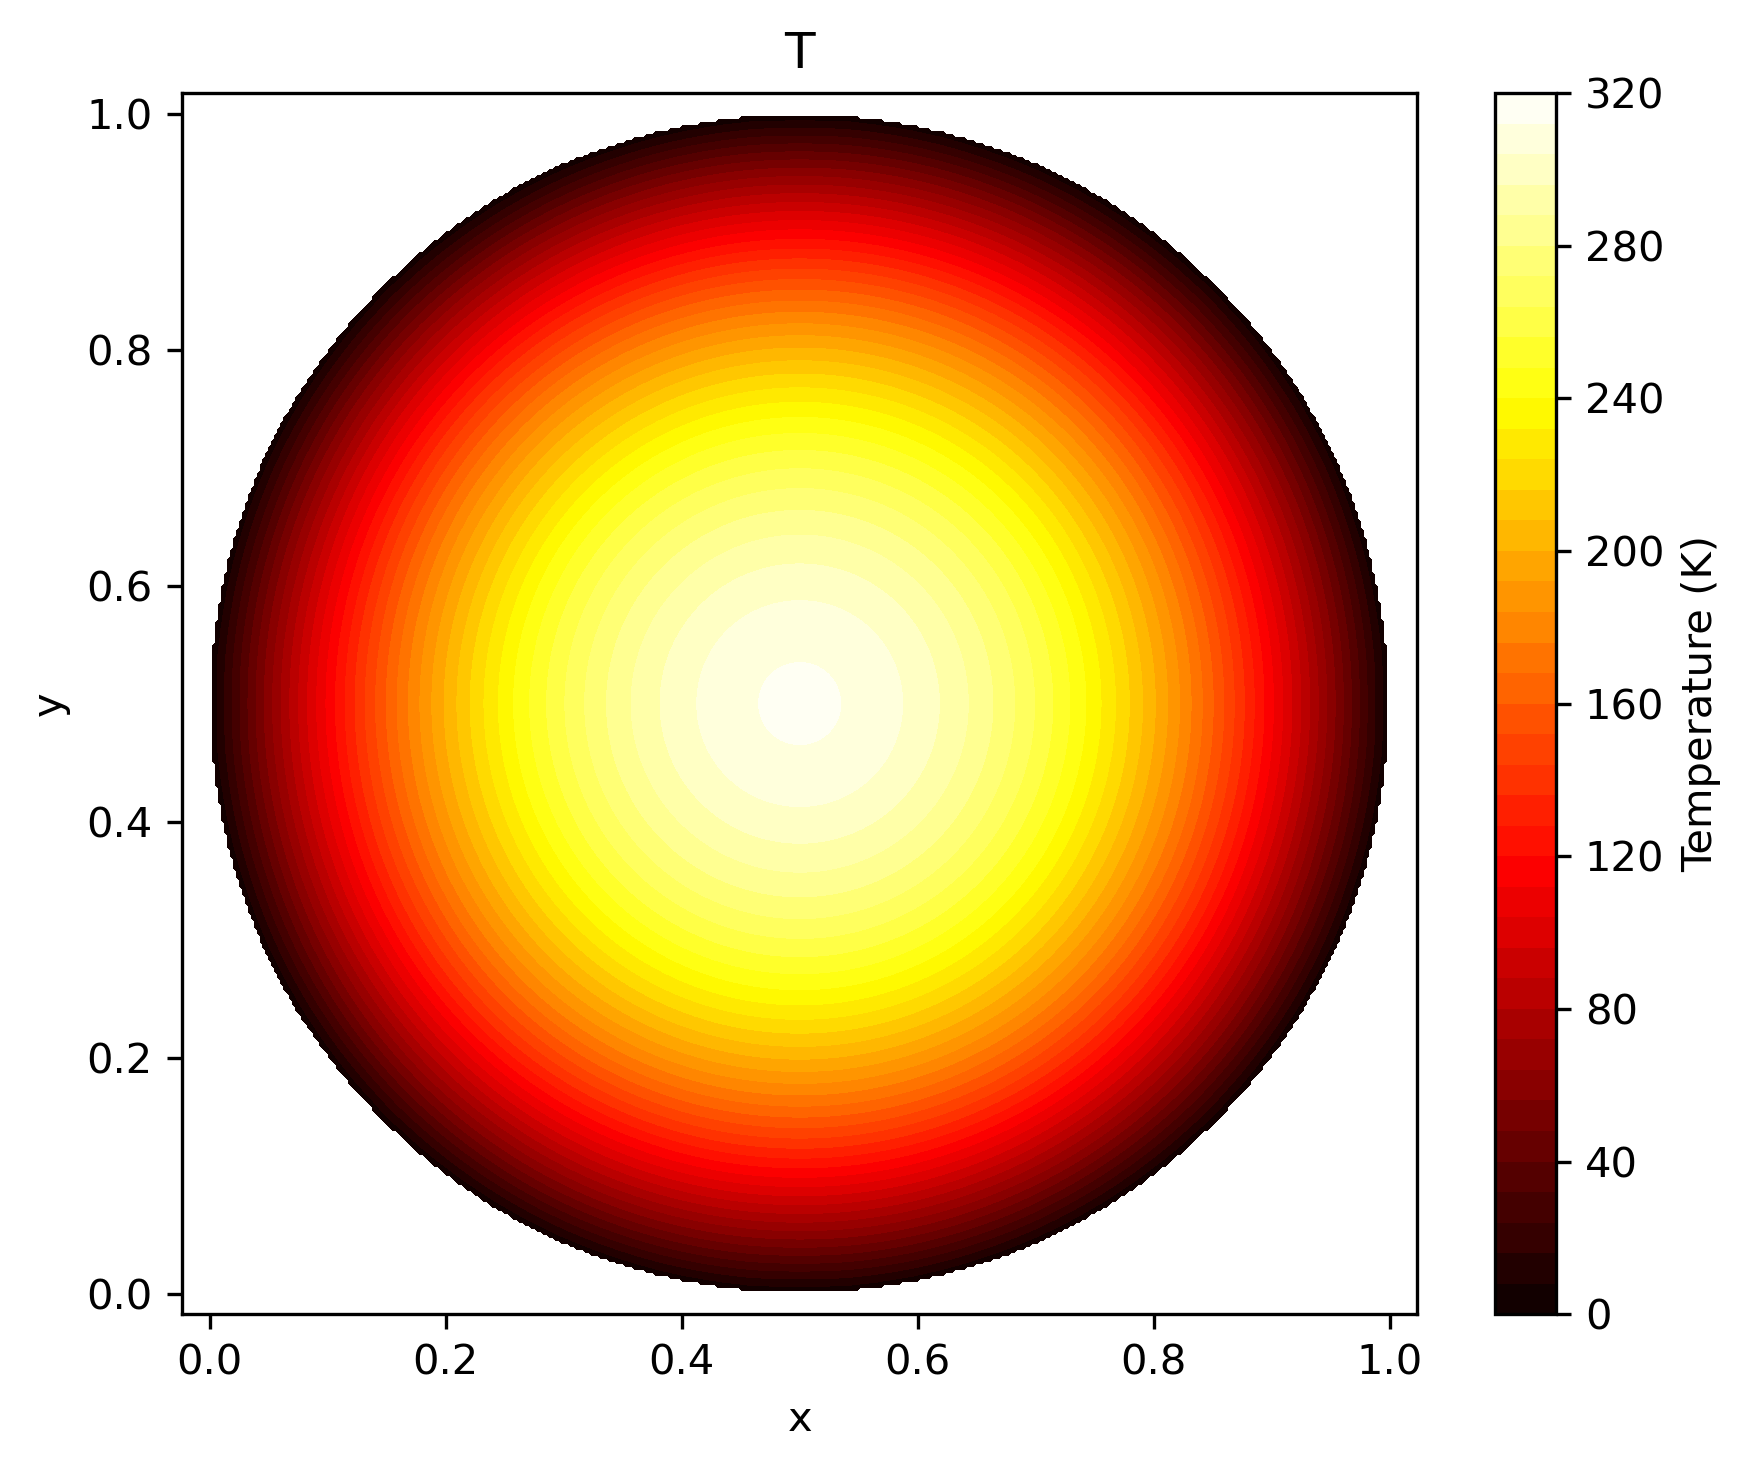

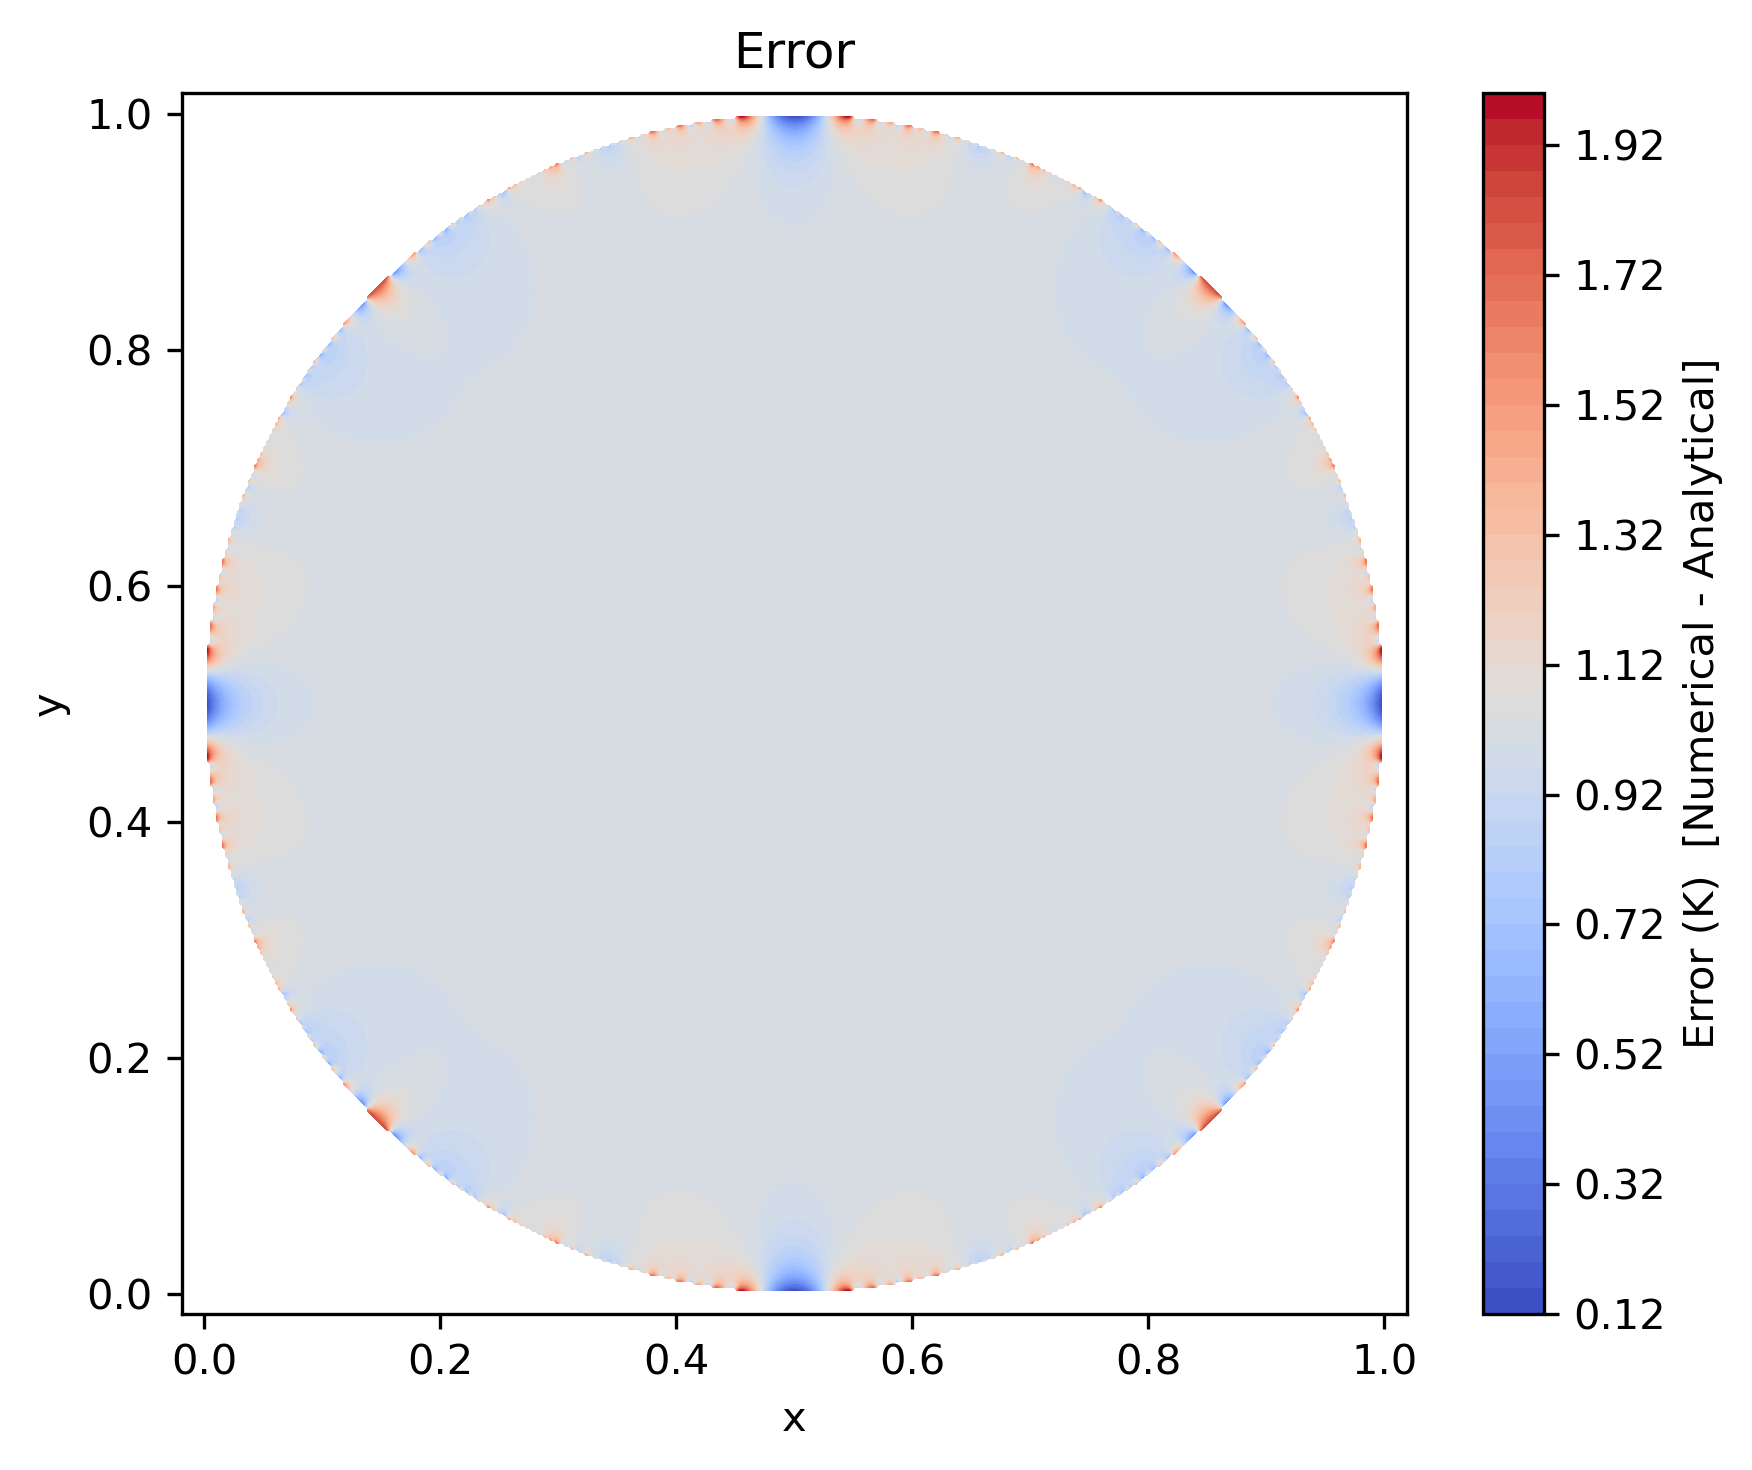

In [ ]:
# --------------------
# Plot (host)
# --------------------
# Convert JAX arrays to regular NumPy arrays for plotting
u_np = np.array(u_final)    # Final simulated temperature
domain_mask_np = np.array(domain_mask)  # Circle mask (1 inside, 0 outside)
X_np, Y_np = np.array(X), np.array(Y)   # Grid coordinates

# Mask out everything outside the circular region
u_masked = ma.masked_where(~domain_mask_np, u_np)

# ---------------------------------------------------------------
# Create a color map showing temperature inside the circle
# ---------------------------------------------------------------
plt.figure(figsize=(6, 5), dpi=300)         # Create a new figure (high quality)
plt.contourf(X_np, Y_np, u_masked, levels=50, cmap='hot')     # Filled contour plot using 'hot' colors
plt.colorbar(label='Temperature (K)')       # Add color scale (in Kelvin)
plt.title("T")                              # Plot title
plt.xlabel('x'); plt.ylabel('y')            # X-axis label, Y-axis label
plt.axis('equal')                           #Keep x and y scaling equal (so circle looks round)
plt.tight_layout()                          #Adjust spacing to fit labels neatly   
plt.savefig('neumann_circular_contour.png', dpi=300)    # Save image to file
plt.show()                          # Display the plot on screen

# ---------------------------------------------------------------
# Create a second plot showing the error
# ---------------------------------------------------------------
# This shows where the simulation and exact solution differ.
# Red and blue areas indicate where the solver slightly over-
# or under-estimated the temperature.
# ---------------------------------------------------------------
err_np = np.array(err_field)        # Convert error field to NumPy
err_masked = ma.masked_where(~domain_mask_np, err_np)   # Hide values outside the circle
plt.figure(figsize=(6, 5), dpi=300)
plt.contourf(X_np, Y_np, err_masked, levels=50, cmap='coolwarm')    # Use blue/red map for error
plt.colorbar(label='Error (K)  [Numerical - Analytical]')
plt.title("Error")
plt.xlabel('x'); plt.ylabel('y'); plt.axis('equal'); plt.tight_layout()
plt.savefig('error_contour.png', dpi=300)   # Save error map
plt.show()     #Display on screen

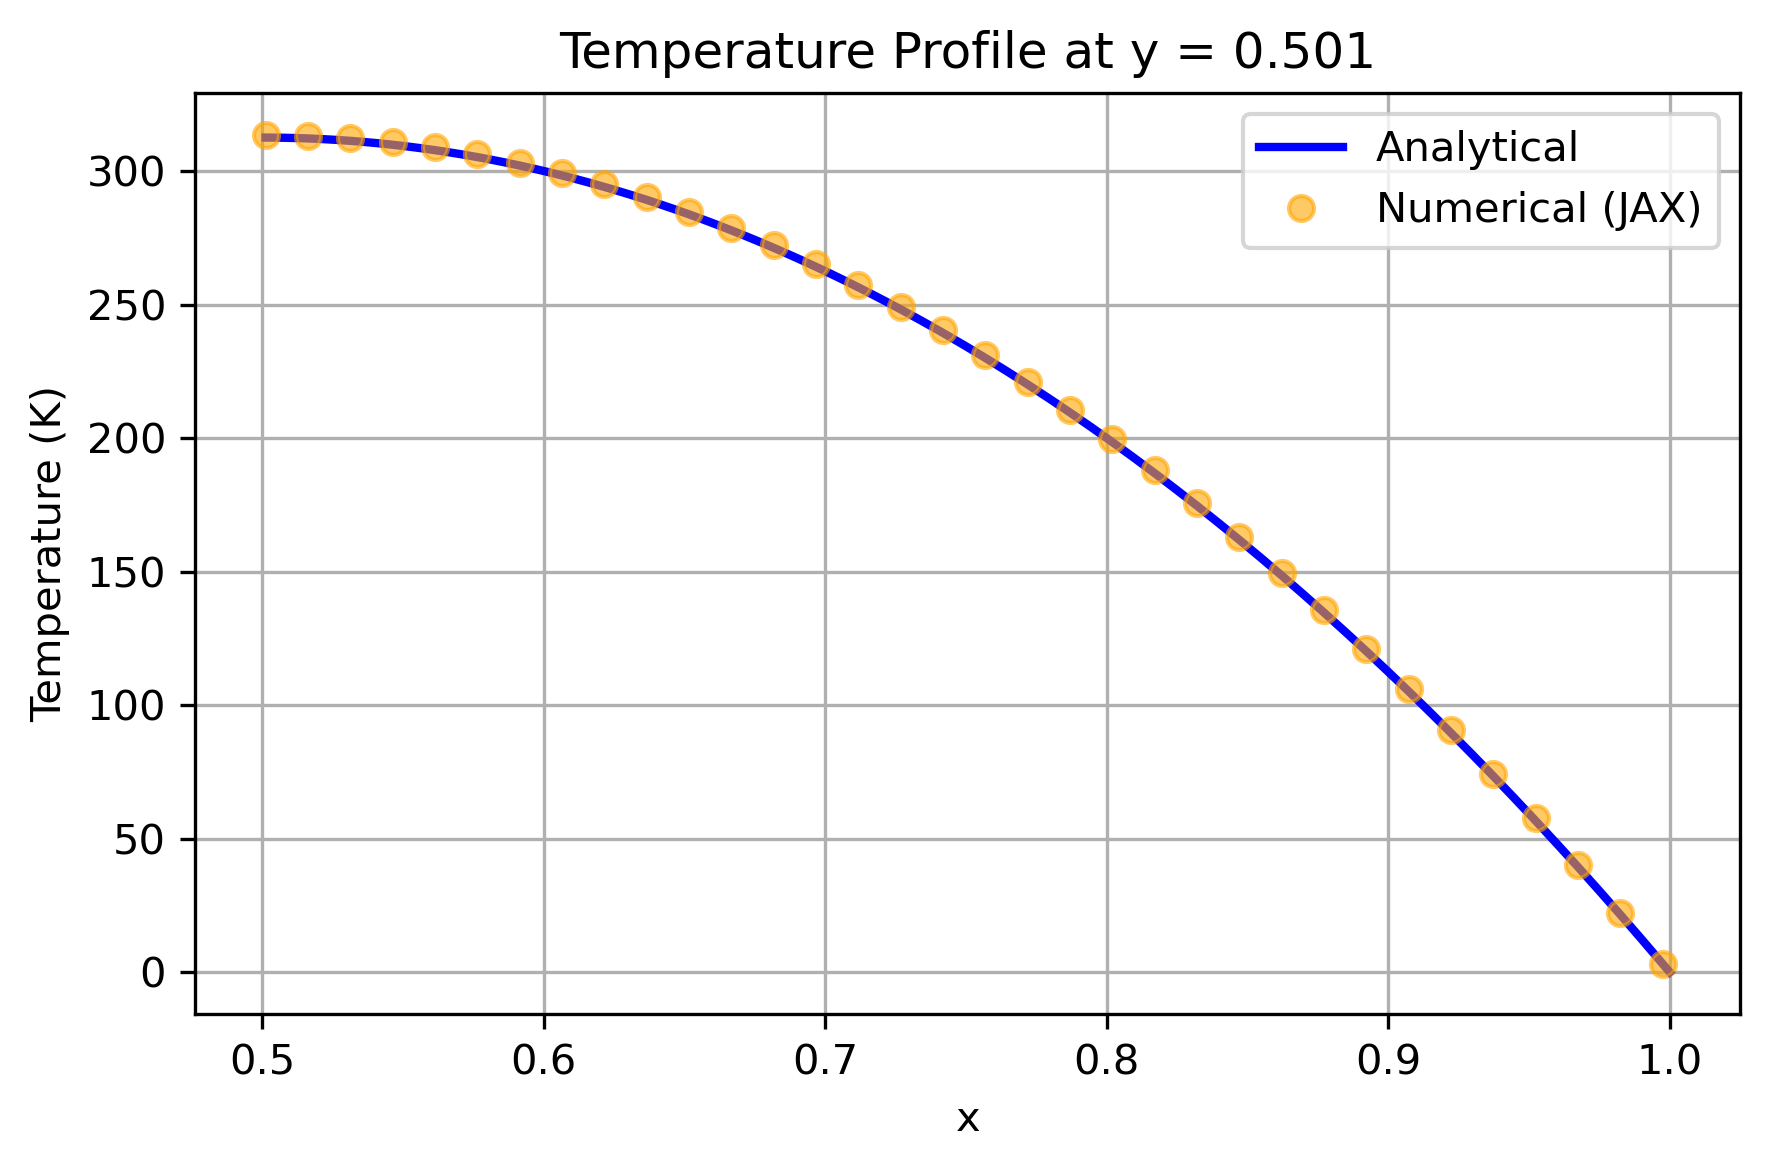

In [ ]:
# ---------- Temperature profile at y = 0.5, x in [0.5, 1.0] ----------
# Convert x and y grid coordinates from JAX to NumPy
x_np = np.array(x)
y_np = np.array(y)

# 1.Find the row closest to y = 0.5 (the horizontal diameter through the center)
y_target = 0.5
# Find which row in the grid is closest to y = 0.5
y_index = int(np.abs(y_np - y_target).argmin())

# 2.Restrict x to the right half: [0.5, 1.0]
x_start, x_end = 0.5, 1.0
# Create a mask that only selects x-values in this range
x_mask = (x_np >= x_start) & (x_np <= x_end)
# Apply the mask to get the x-values and corresponding temperatures
x_profile = x_np[x_mask]
u_profile = u_np[y_index, x_mask]       # Numerical temperature along y = 0.5

# 3.Analytical (True) profile along this diameter
# Calculate the radial distance from the center for each x point
r_profile = np.abs(x_profile - cx)
# Analytical temperature equation for a circular plate with heat generation
T_profile_analytical = 0.25 * (q_dot / k) * (R_domain**2 - r_profile**2)

# 4.Choose every nth point for numerical dots
# Only use every 6th point to reduce clutter when plotting
step = 6
x_profile_sparse = x_profile[::step]
u_profile_sparse = u_profile[::step]

# 5.Plot comparison between analytical and numerical results
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(x_profile, T_profile_analytical, color='blue', lw=2, label='Analytical')   # Continuous analytical curve
plt.plot(x_profile_sparse, u_profile_sparse, 'o', color='orange', markersize=6, alpha=0.6, label='Numerical (JAX)') # Discrete points

# Add labels and formatting
plt.title(f"Temperature Profile at y = {y_np[y_index]:.3f}")    # Title shows which line was plotted
plt.xlabel("x")                                     # X-axis: position
plt.ylabel("Temperature (K)")                       # Y-axis: temperature in Kelvin   
plt.grid(True)                                      # Add gridlines for readability
plt.legend()                                        # Add legend for curve identification
plt.tight_layout()                                  # Adjust layout so labels fit neatly
plt.savefig('neumann_circular_plot.png', dpi=300)   # Save the figure as an image file
plt.show()              # Display the plot